# Segmenting Customer Data using Cluster Analysis

In [1]:
from initial_cleaning import initial_cleaning

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

%matplotlib inline
sns.set_style('white')
pd.options.display.float_format = '{:.3f}'.format
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_context('notebook', font_scale=1.5)

In [2]:
mall = pd.DataFrame(initial_cleaning('/Users/jamilab/Data_Science/Data_Sets/Mall_Customers.csv'))

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [3]:
# count rows & columns

mall.shape

(200, 5)

In [4]:
# drop customer id column

mall = mall.drop(['CustomerID'], 1)

In [5]:
# rename columns

mall = mall.rename(columns={'Annual Income (k$)' : 'Annual_Income', 'Spending Score (1-100)' : 'Spend_Score'})

In [6]:
# check data types

mall.dtypes

Gender           object
Age               int64
Annual_Income     int64
Spend_Score       int64
dtype: object

In [7]:
mall.describe()

,Age,Annual_Income,Spend_Score
count,200.000,200.000,200.000
mean,38.850,60.560,50.200
std,13.969,26.265,25.824
min,18.000,15.000,1.000
25%,28.750,41.500,34.750
50%,36.000,61.500,50.000
75%,49.000,78.000,73.000
max,70.000,137.000,99.000


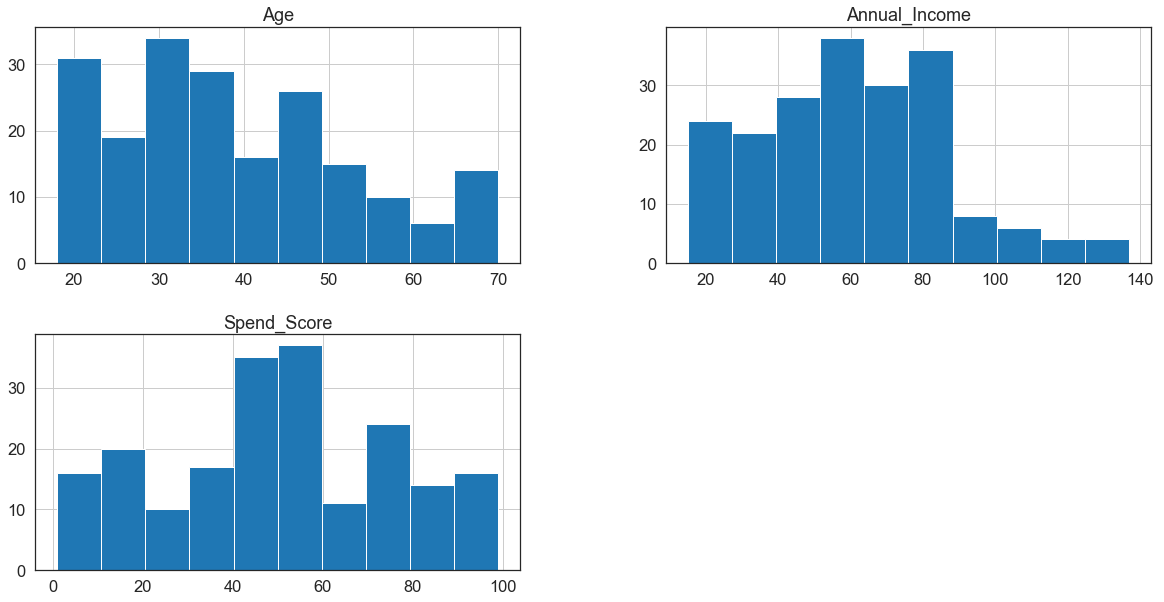

In [8]:
# Visualize the data

mall.hist()
plt.show();

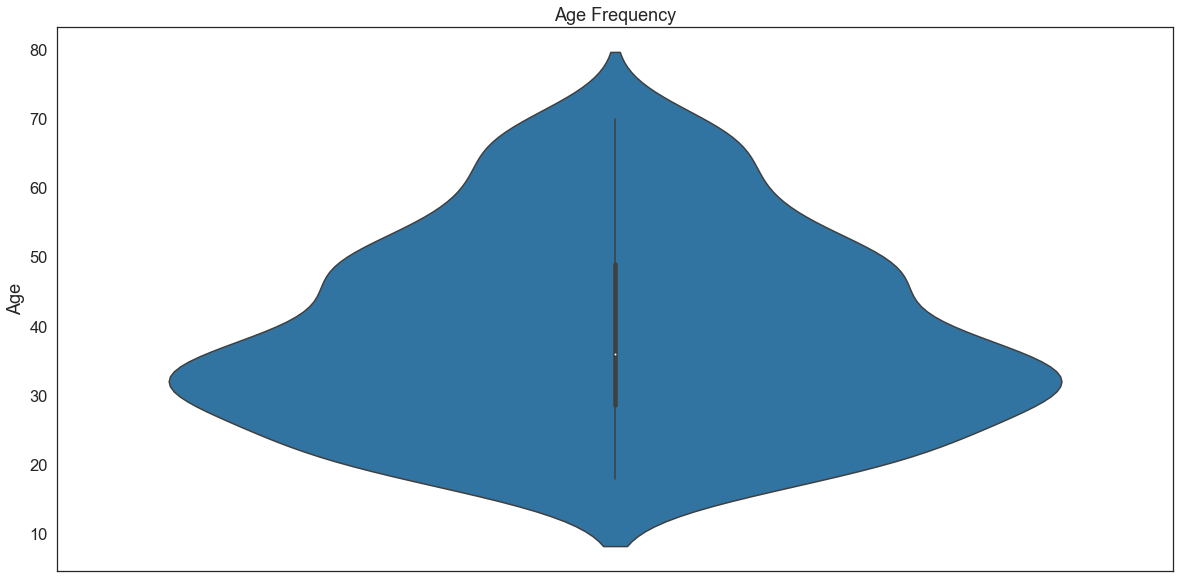

In [9]:
plt.title('Age Frequency')
sns.violinplot(y=mall['Age'])
plt.show();

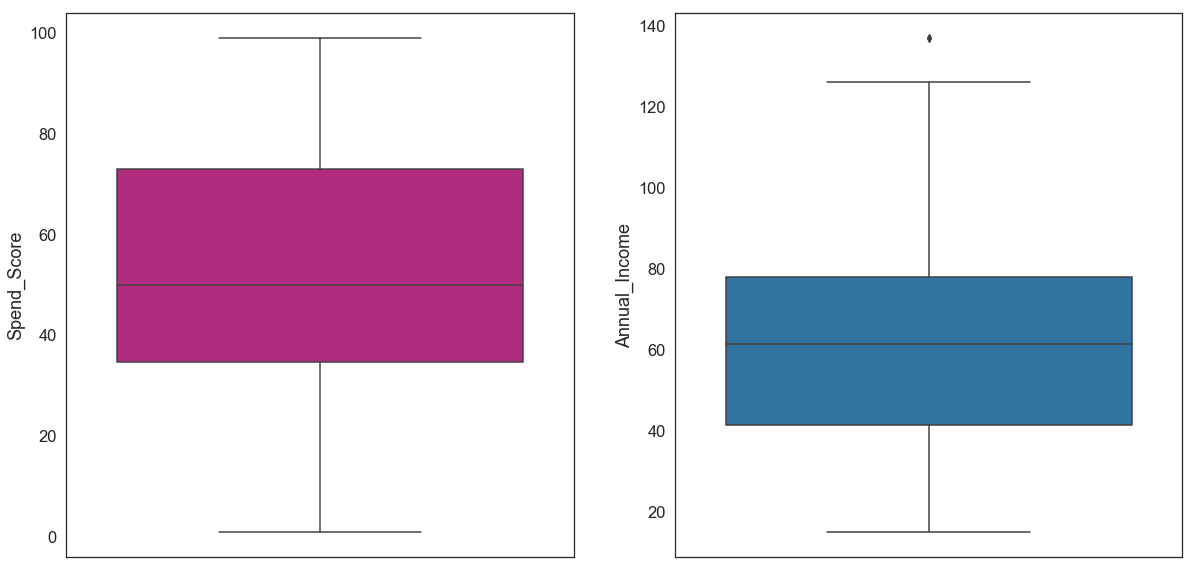

In [10]:
plt.subplot(1,2,1)
sns.boxplot(y=mall['Spend_Score'], color='mediumvioletred')
plt.subplot(1,2,2)
sns.boxplot(y=mall['Annual_Income'])
plt.show();

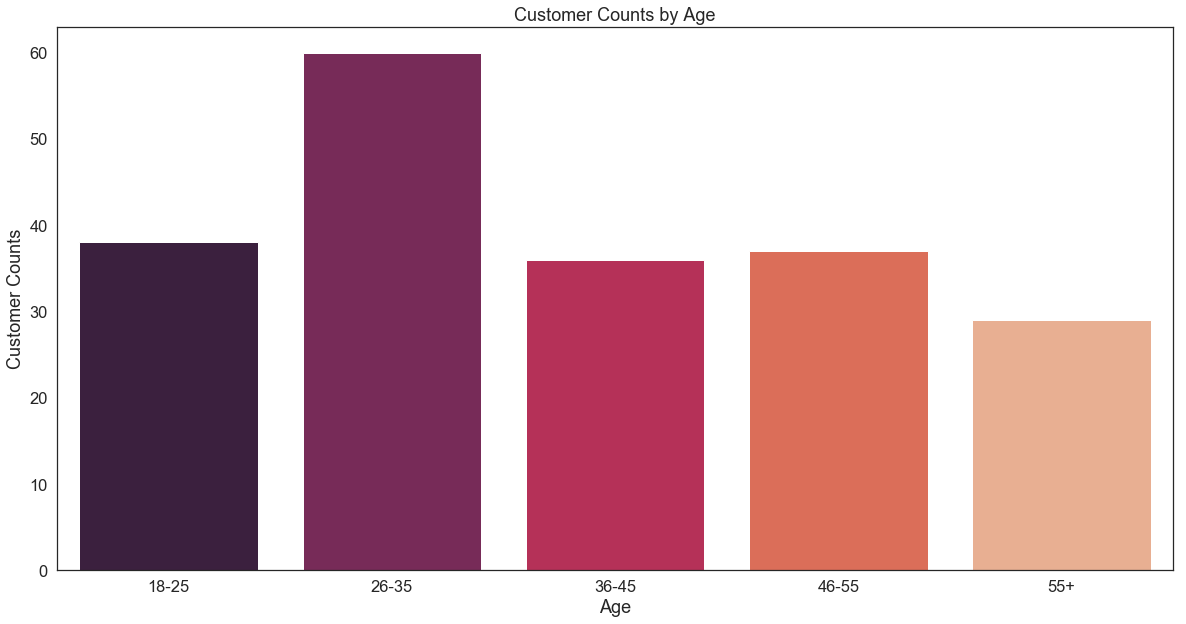

In [12]:
age18_25 = mall.Age[(mall.Age <= 25) & (mall.Age >= 18)]
age26_35 = mall.Age[(mall.Age <= 35) & (mall.Age >= 26)]
age36_45 = mall.Age[(mall.Age <= 45) & (mall.Age >= 36)]
age46_55 = mall.Age[(mall.Age <= 55) & (mall.Age >= 46)]
age55above = mall.Age[mall.Age >= 56]

x = ['18-25', '26-35', '36-45', '46-55', '55+']
y = [len(age18_25.values),len(age26_35.values),len(age36_45.values),len(age46_55.values),len(age55above.values)]

sns.barplot(x=x, y=y, palette='rocket')
plt.title('Customer Counts by Age')
plt.xlabel('Age')
plt.ylabel('Customer Counts')
plt.show();

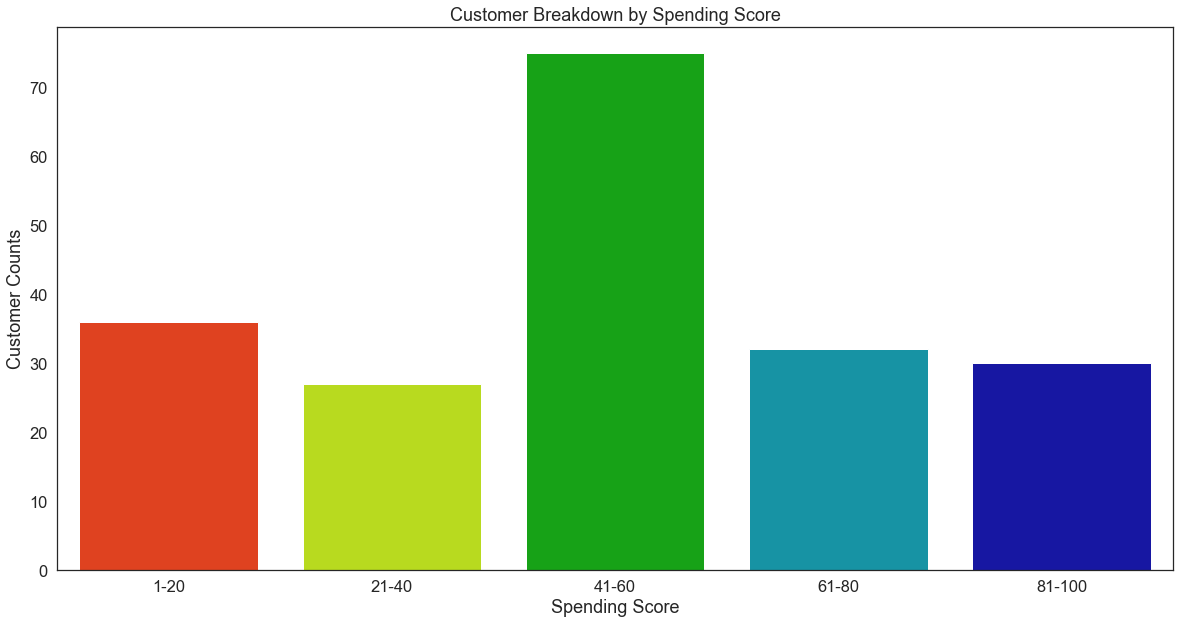

In [15]:
ss1_20 = mall['Spend_Score'][(mall['Spend_Score'] >= 1) & (mall['Spend_Score'] <= 20)]
ss21_40 = mall['Spend_Score'][(mall['Spend_Score'] >= 21) & (mall['Spend_Score'] <= 40)]
ss41_60 = mall['Spend_Score'][(mall['Spend_Score'] >= 41) & (mall['Spend_Score'] <= 60)]
ss61_80 = mall['Spend_Score'][(mall['Spend_Score'] >= 61) & (mall['Spend_Score'] <= 80)]
ss81_100 = mall['Spend_Score'][(mall['Spend_Score'] >= 81) & (mall['Spend_Score'] <= 100)]

ssx = ['1-20', '21-40', '41-60', '61-80', '81-100']
ssy = [len(ss1_20.values), len(ss21_40.values), len(ss41_60.values), len(ss61_80.values), len(ss81_100.values)]

sns.barplot(x=ssx, y=ssy, palette='nipy_spectral_r')
plt.title('Customer Breakdown by Spending Score')
plt.xlabel('Spending Score')
plt.ylabel('Customer Counts')
plt.show()

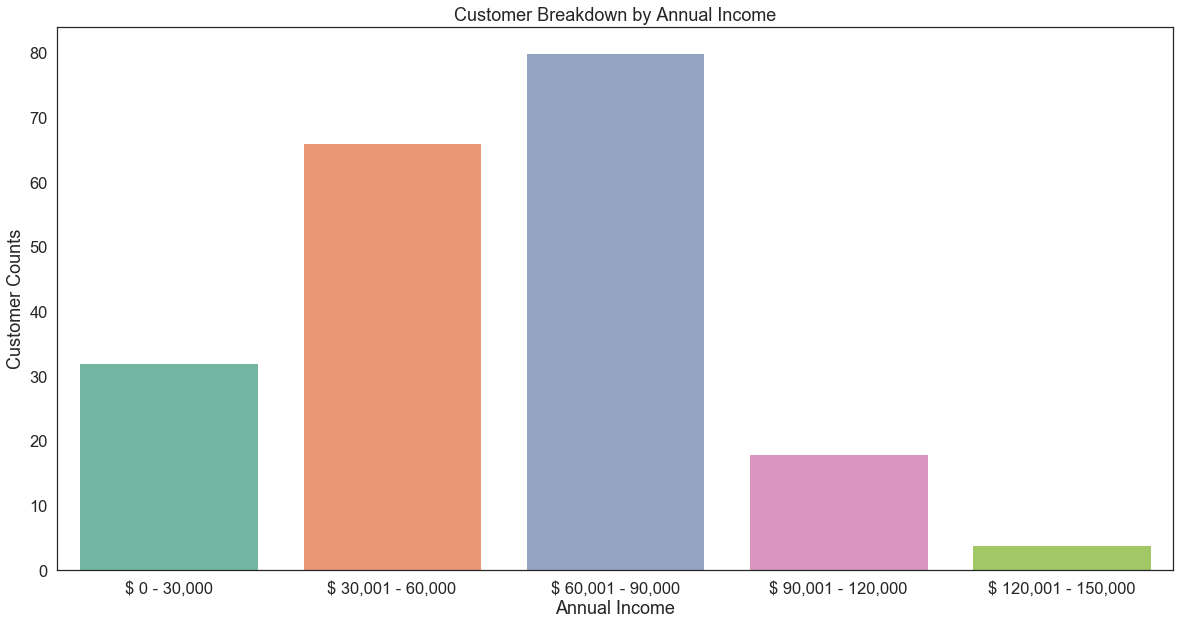

In [16]:
ai0_30 = mall['Annual_Income'][(mall['Annual_Income'] >= 0) & (mall['Annual_Income'] <= 30)]
ai31_60 = mall['Annual_Income'][(mall['Annual_Income'] >= 31) & (mall['Annual_Income'] <= 60)]
ai61_90 = mall['Annual_Income'][(mall['Annual_Income'] >= 61) & (mall['Annual_Income'] <= 90)]
ai91_120 = mall['Annual_Income'][(mall['Annual_Income'] >= 91) & (mall['Annual_Income'] <= 120)]
ai121_150 = mall['Annual_Income'][(mall['Annual_Income'] >= 121) & (mall['Annual_Income'] <= 150)]

aix = ['$ 0 - 30,000', '$ 30,001 - 60,000', '$ 60,001 - 90,000', '$ 90,001 - 120,000', '$ 120,001 - 150,000']
aiy = [len(ai0_30.values), len(ai31_60.values), len(ai61_90.values), len(ai91_120.values), len(ai121_150.values)]

sns.barplot(x=aix, y=aiy, palette='Set2')
plt.title('Customer Breakdown by Annual Income')
plt.xlabel('Annual Income')
plt.ylabel('Customer Counts')
plt.show();

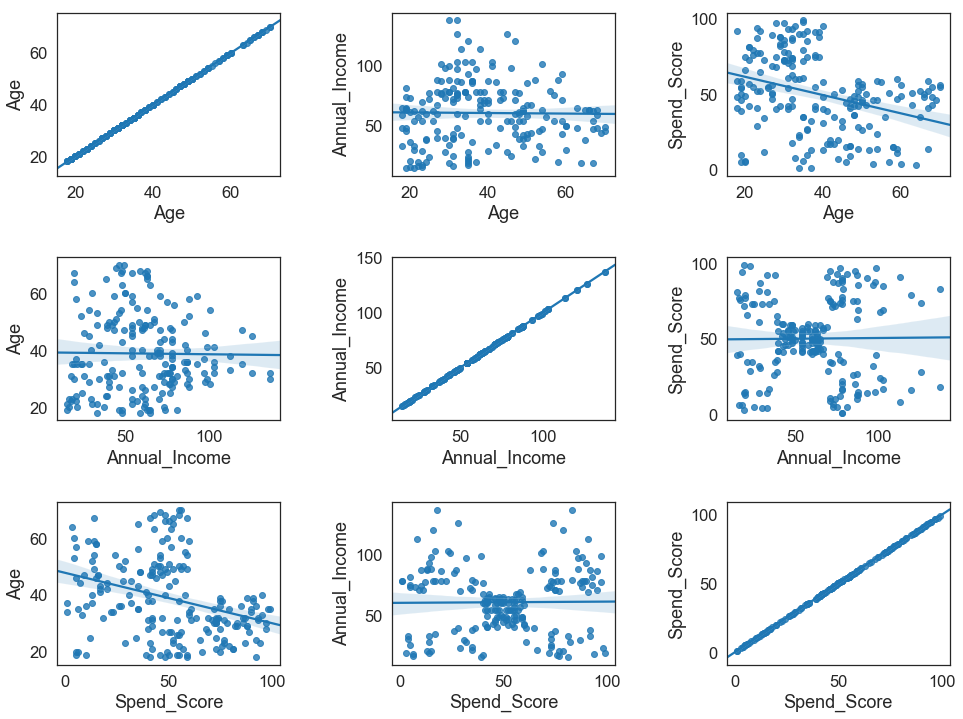

In [18]:
# use a regression plot to see correlations

plt.figure(1 , figsize = (16 , 12))
n = 0 
for x in ['Age' , 'Annual_Income' , 'Spend_Score']:
    for y in ['Age' , 'Annual_Income' , 'Spend_Score']:
        n += 1
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = mall)
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )
plt.show();

In [19]:
# Age and Spending Score

X = mall[['Age' , 'Spend_Score']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X)
    inertia.append(algorithm.inertia_)

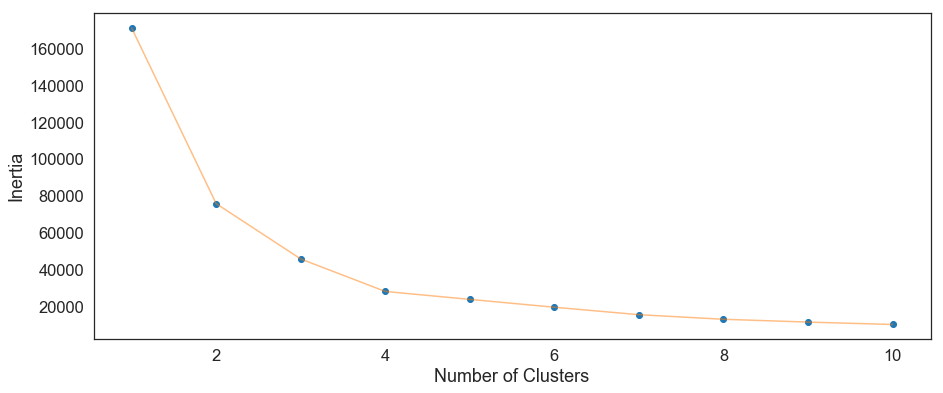

In [20]:
# plot for optimal number of clusters

plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [21]:
algorithm = (KMeans(n_clusters = 4 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

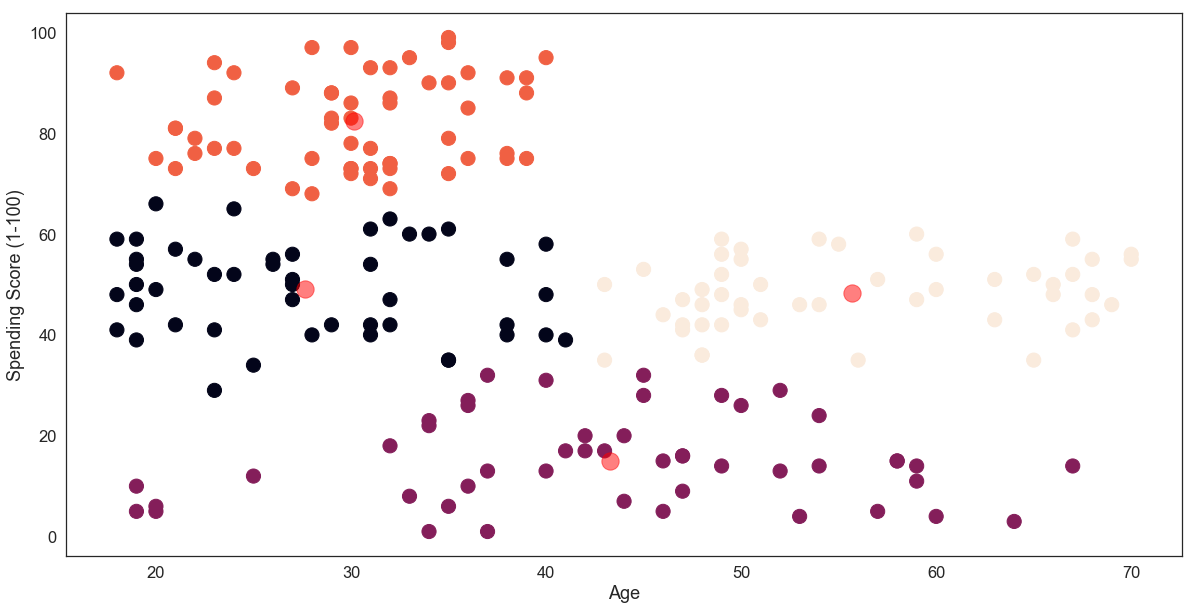

In [22]:
plt.clf()
plt.scatter( x = 'Age' ,y = 'Spend_Score' , data = mall , c = labels1 , 
            s = 200 )
plt.scatter(x = centroids1[: , 0] , y =  centroids1[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('Spending Score (1-100)') , plt.xlabel('Age')
plt.show()

In [23]:
# Annual Income and Spending Score

X2 = mall[['Annual_Income' , 'Spend_Score']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X2)
    inertia.append(algorithm.inertia_)

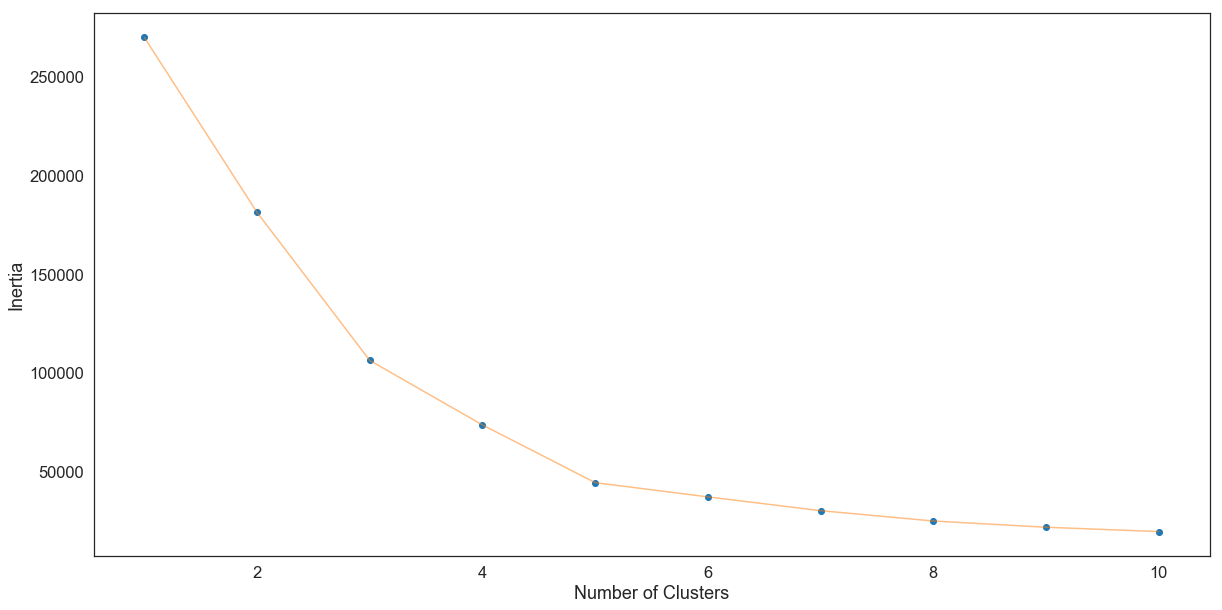

In [24]:
# plot for optimal number of clusters

plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show();

In [25]:
algorithm = (KMeans(n_clusters = 5 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X2)
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

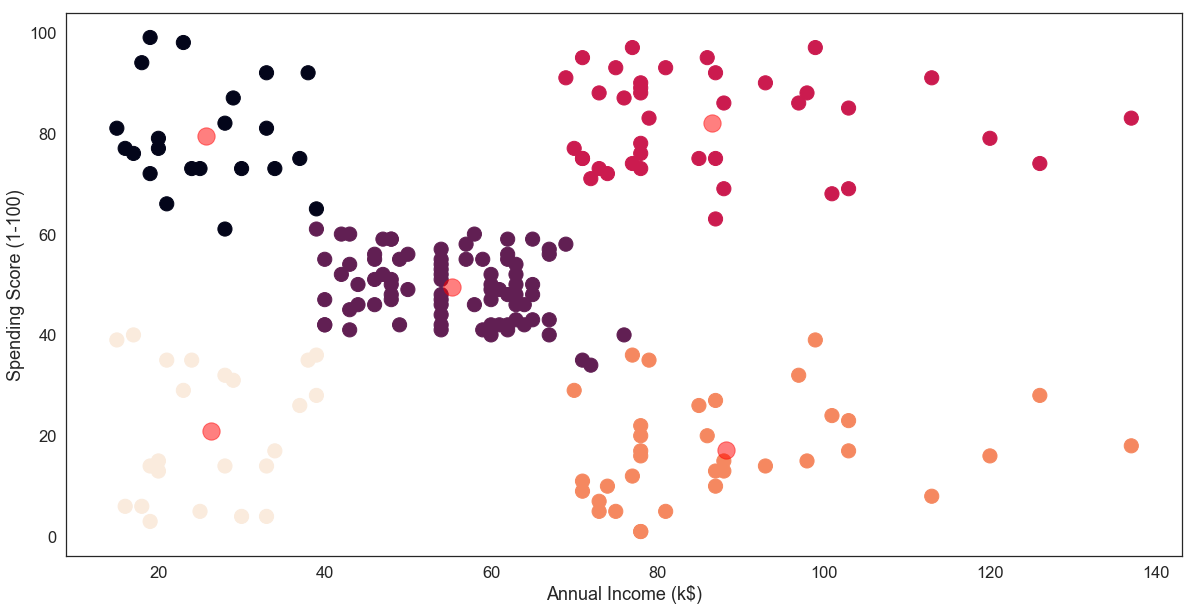

In [26]:
plt.clf()
plt.scatter( x = 'Annual_Income' ,y = 'Spend_Score' , data = mall , c = labels2 , 
            s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('Spending Score (1-100)') , plt.xlabel('Annual Income (k$)')
plt.show();